In [35]:
import acl
import numpy as np
from PIL import Image, ImageDraw
from acl_sample import Sample
import struct
from constant import NPY_BYTE, ACL_MEMCPY_DEVICE_TO_HOST, ACL_MEM_MALLOC_NORMAL_ONLY, ACL_MEMCPY_HOST_TO_DEVICE
from postprocessing import postprocess_boxes
import cv2
import matplotlib.pyplot as plt

In [36]:
with open("data/coco.names") as fd:
    coco_labels = fd.readlines()

coco_labels = [i[:-1] for i in coco_labels][1:]

In [56]:
device_id = 0
input_size = 416
model_path = "./model/yolov3_caffe.om"
img_dict = {"path": "./data/kite.jpg", "dtype": np.uint8}

In [57]:
sample = Sample(device_id,
                model_path,
                input_size,
                input_size)

[Sample] init resource stage:
[Sample] init resource stage success
[Model] class Model init resource stage:
[Model] create model output dataset:
[Model] create model output dataset success
model input size 2
input  0
model input dims ({'name': 'data', 'dimCount': 4, 'dims': [1, 416, 416, 3]}, 0)
model input datatype 4
input  1
model input dims ({'name': 'img_info', 'dimCount': 2, 'dims': [1, 4]}, 0)
model input datatype 0
model output size 2
output  0
model output dims ({'name': 'detection_out3:0:box_out', 'dimCount': 2, 'dims': [1, 6144]}, 0)
model output datatype 0
output  1
model output dims ({'name': 'detection_out3:1:box_out_num', 'dimCount': 2, 'dims': [1, 8]}, 0)
model output datatype 3
[Model] class Model init resource stage success


In [39]:
img_device, img_buffer_size = sample.transfer_to_device(img_dict["path"], img_dict["dtype"])

In [40]:
im = Image.open(img_dict["path"])
width, height = im.size
print(width, height)

1352 900


In [41]:
dvpp_output_buffer, dvpp_output_size = \
            sample.dvpp_process.run(img_device,
                                  img_buffer_size,
                                  width,
                                  height)

[Dvpp] vpc decode stage:
decode_out_buffer_size: 1926144
temp_width:%d,temp_height:$d 1352 900
[Dvpp] vpc decode stage success
[Dvpp] vpc resize stage:
decode_out_buffer_size: 1926144
temp_width:%d,temp_height:$d 1352 900
decode_out_buffer_size: 259584
temp_width:%d,temp_height:$d 416 416
[Dvpp] crop and paste roi config success
[Dvpp] vpc resize stage success
17592192335872 259584


In [43]:
# %timeit -n 100 -r 10
boxes = sample.forward(img_dict)

[Sample] width:1352 height:900
[Sample] image:./data/kite.jpg
[Dvpp] vpc decode stage:
decode_out_buffer_size: 1926144
temp_width:%d,temp_height:$d 1352 900
[Dvpp] vpc decode stage success
[Dvpp] vpc resize stage:
decode_out_buffer_size: 1926144
temp_width:%d,temp_height:$d 1352 900
decode_out_buffer_size: 259584
temp_width:%d,temp_height:$d 416 416
[Dvpp] crop and paste roi config success
[Dvpp] vpc resize stage success
17592192598016 259584
dvpp_output_size 259584
[Model] create model input dataset:
input2 [ 416.  416.  900. 1352.], size:4
[Model] create model input dataset success
[Model] execute stage:
[Model] execute stage success
result ouput 13
{'x1': 83.1875, 'y1': 511.5, 'x2': 107.4375, 'y2': 565.0, 'detection_scores': 0.9912109375, 'detection_classes': 0.0}
{'x1': 116.1875, 'y1': 612.5, 'x2': 166.0, 'y2': 761.0, 'detection_scores': 0.9794921875, 'detection_classes': 0.0}
{'x1': 30.375, 'y1': 518.5, 'x2': 50.25, 'y2': 558.0, 'detection_scores': 0.962890625, 'detection_classes'

In [44]:
img = Image.open(img_dict["path"])

In [45]:
img1 = ImageDraw.Draw(img)
for i in range(boxes["num_detections"]):
    box = boxes[i]
    img1.rectangle([box["x1"], box["y1"], box["x2"], box["y2"]], outline ="red", width=2)
    print(box["x1"], box["y1"], box["x2"], box["y2"], box["detection_scores"], box["detection_classes"], coco_labels[int(box["detection_classes"])])

83.1875 511.5 107.4375 565.0 0.9912109375 0.0 person
116.1875 612.5 166.0 761.0 0.9794921875 0.0 person
30.375 518.5 50.25 558.0 0.962890625 0.0 person
216.5 698.5 270.25 852.5 0.94921875 0.0 person
523.0 504.5 541.5 532.0 0.943359375 0.0 person
347.25 487.0 356.75 506.75 0.9423828125 0.0 person
179.5 549.5 193.125 569.5 0.8076171875 0.0 person
594.0 84.375 672.5 157.75 0.95751953125 33.0 kite
280.0 237.25 308.25 286.25 0.79541015625 33.0 kite
306.25 378.75 326.5 392.75 0.6953125 33.0 kite
579.5 348.0 600.5 367.0 0.63671875 33.0 kite
467.5 341.0 487.25 360.25 0.63330078125 33.0 kite
1083.0 396.5 1106.0 421.25 0.529296875 33.0 kite


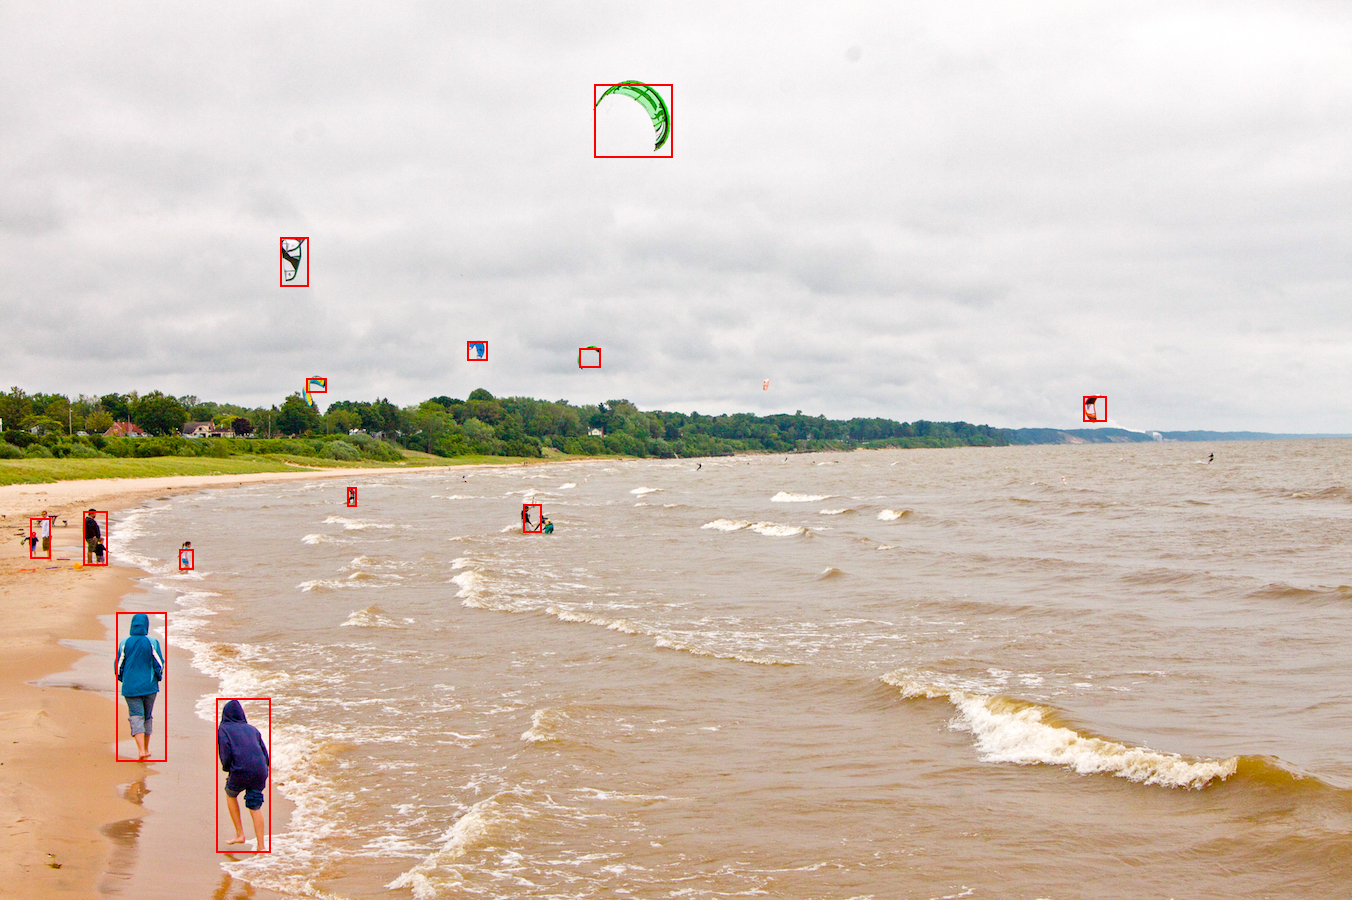

In [46]:
img